# Testing the augmentation class 


In [5]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
from scipy.ndimage import gaussian_filter
import tensorflow as tf
from pathlib import Path
import numpy as np
import rasterio


class ImageDataLoader:
    """
    This class prepares the tensorflow dataset for training:
    - Loads and processes the images and masks
    - Applies data augmentation: Flipping, Rotating, Adds noise, gaussian blur and zooming in.
    """

    def __init__(self, data_path):
        self.data_path = Path(data_path)
        self.base_path = self.data_path.parent
        self.satellite_dir = self.base_path / 'satellite'
        self.mask_dir = self.base_path / 'mask'

    def process_image(self, image_path):
        """
        Tensorflow function to process the satellite images for tensorflow datasets.
        :param image_path: A string of the image path
        :return: tensorflow compatible float32 image
        """

        def _load_image(path):
            with rasterio.open(path.decode("utf-8")) as src:
                image = src.read().transpose((1, 2, 0))
                return image.astype(np.float32)

        tensor = tf.numpy_function(_load_image, [image_path], tf.float32)
        tensor.set_shape([1024, 1024, 4])
        return tensor

    def process_mask(self, mask_path):
        """
        Tesnorflow function to process the masks for tensorflow datasets
        :param mask_path: A string of the mask path
        :return: tensorflow compatible uint8 image
        """

        def _load_mask(path):
            with rasterio.open(path.decode("utf-8")) as src:
                mask = src.read(1)
                mask = np.expand_dims(mask,
                                      -1)  # Adds a new dimension in the end of the array (height, width, channels=1)
                return mask.astype(np.uint8)

        tensor = tf.numpy_function(_load_mask, [mask_path], tf.uint8)
        tensor.set_shape([1024, 1024, 1])
        return tensor
    
    
    # Add the augmentation here:
    def add_horizontal_flip(self, image, mask):
        """
        Flip image horizontally
        """
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)
        return image, mask
    
    
    
    
    def augment(self, image, mask):
        
        # Adds a horizontal flip to the image and mask with a 50% probability
        if np.random.rand() > 0.5:
            image, mask = self.add_horizontal_flip(image, mask)
        return image, mask
        
    
    def prepare_dataset(self, image_paths, mask_paths, batch_size):
        dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
        dataset = dataset.map(lambda x, y: (self.process_image(x), self.process_mask(y)),
                              num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(self.augment, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(tf.data.AUTOTUNE)
        return dataset

    
 
            
    

In [12]:
image_paths = ["./data/satellite/AG_parcel_10.tif"]
mask_paths = ["./data/mask/AG_parcel_10_mask.tif"]

loader = ImageDataLoader("./data/")
dataset = loader.prepare_dataset(image_paths, mask_paths, batch_size=1)

Final image shape: (1, 1024, 1024, 4)
Final mask shape: (1, 1024, 1024, 1)


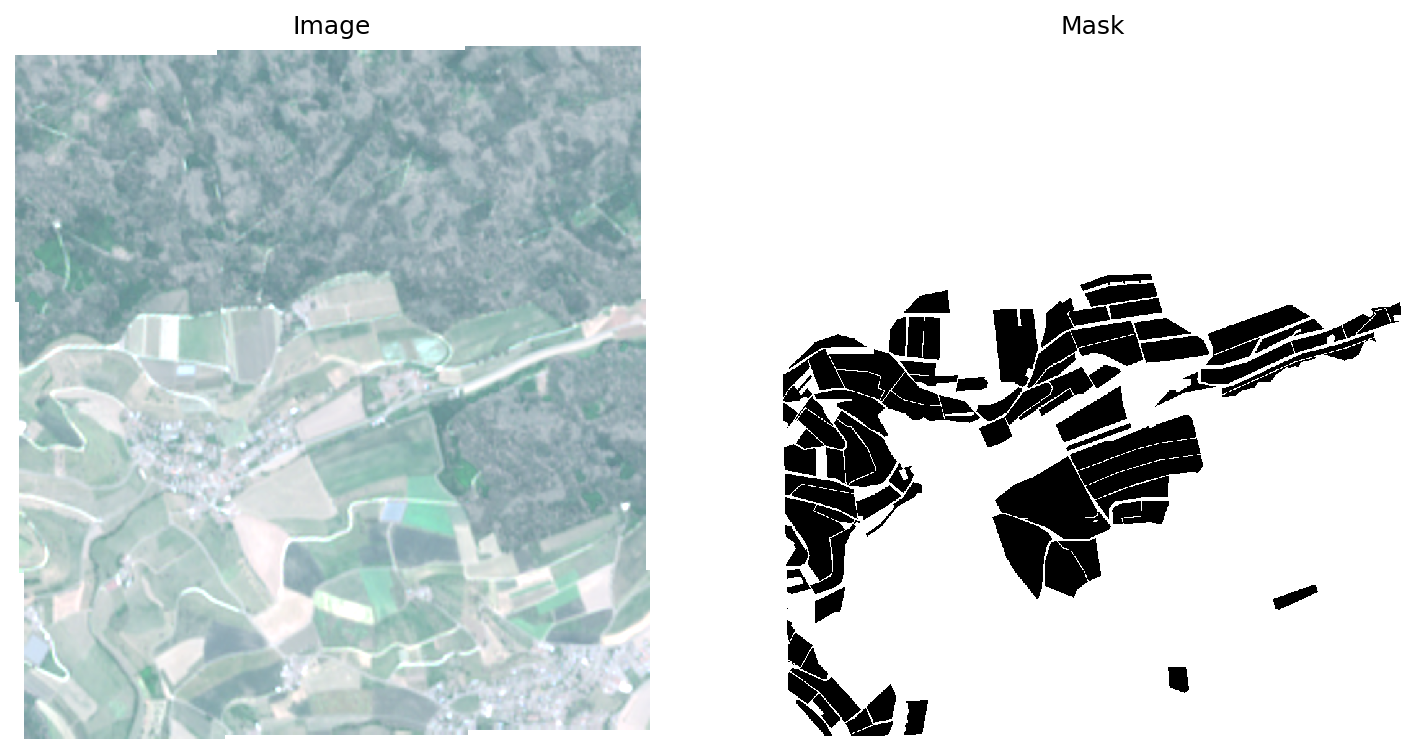

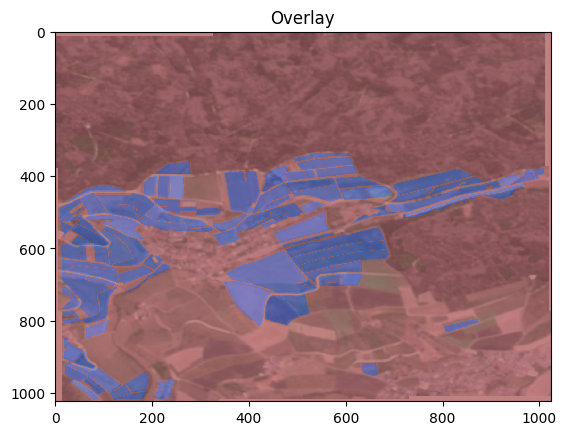

In [14]:
from matplotlib import pyplot as plt
for image, mask in dataset.take(1):
    print("Final image shape:", image.shape)
    print("Final mask shape:", mask.shape)
    image_np = image.numpy()  # Convert tensors to numpy arrays
    mask_np = mask.numpy()

    # Assuming image and mask are correctly shaped and scaled [0, 1] for visualization
    image_np = np.clip(image_np[0], 0, 1)  # Clip values to [0, 1] range and remove batch dimension
    mask_np = mask_np[0, :, :, 0]  # Remove batch dimension and channel dimension for mask

    plt.figure(figsize=(12, 6), dpi=150)  # Higher DPI
    
    plt.subplot(1, 2, 1)
    plt.imshow(image_np, interpolation='nearest', aspect='auto')  # Adjust interpolation and aspect ratio
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask_np, cmap='gray', interpolation='nearest', aspect='auto')
    plt.title("Mask")
    plt.axis('off')

    plt.show()
    
    # Lay the image and mask on top of each other
    plt.imshow(image_np, interpolation='nearest', aspect='auto')
    plt.imshow(mask_np, cmap='jet', alpha=0.5, interpolation='nearest', aspect='auto')
    plt.title("Overlay")
    
    plt.show()
    


    